In [1]:
%cd ..

c:\Projects\Groningen-Waste-Collection


In [2]:
import sqlite3

import folium
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from folium.plugins import FastMarkerCluster

In [3]:
%matplotlib inline

plt.rcParams.update({
    'legend.fontsize': 10,
    'axes.labelsize': 12,
    'axes.titlesize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titlepad': 15,
    'figure.figsize': (12, 4),
})

## Read data

We store everything in a simple SQL database, in multiple tables.
For this notebook it's helpful if we get that data into data frames instead.
Luckily `pandas` offers helpful tools for working with SQL data.

In [4]:
with sqlite3.connect("data/waste.db") as con:
    locations = pd.read_sql("SELECT * FROM locations", con)
    containers = pd.read_sql("SELECT * FROM containers", con)
    arrivals = pd.read_sql("SELECT * FROM arrivals", con, parse_dates=['date'])
    services = pd.read_sql("SELECT * FROM services", con, parse_dates=['date'])

In [5]:
len(containers)

850

In [6]:
containers.num_containers.sum()

1120

## A plot of all containers

Just to get a feel for where they are.
Because there's so many of them (>1000), I'm using a clustering at higher zoom levels.

In [7]:
m = folium.Map(location=[53.2189617, 6.5679106])
m.add_child(FastMarkerCluster(locations[['latitude', 'longitude']].values.tolist()))
m

Above: a map of the depot and all containers in the database.
Note that there are quite a few locations outside Groningen as well.

## Exploring the arrival data

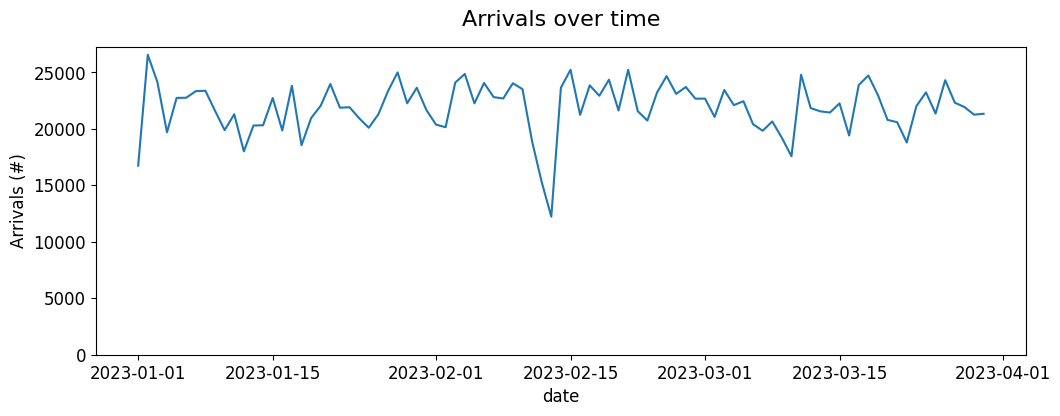

In [8]:
ax = arrivals.container.groupby(arrivals.date.dt.date).count().plot()
ax.set_ylim(bottom=0)
ax.set_ylabel("Arrivals (#)")
ax.set_title("Arrivals over time");

Above: arrivals at all containers (aggregate). The significant drop mid-February is when the strike occurred. 

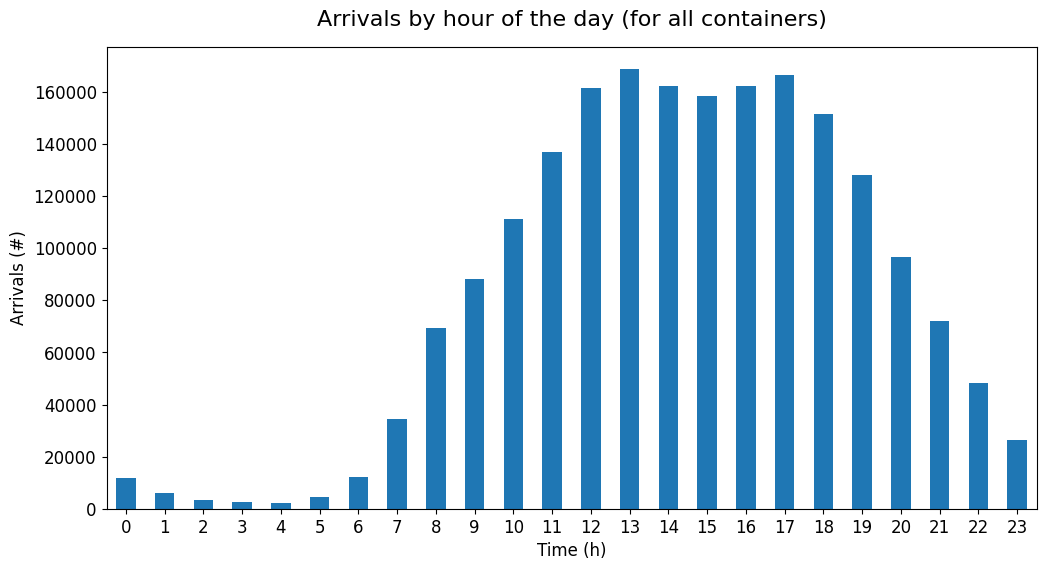

In [9]:
ax = arrivals.date.groupby(arrivals.date.dt.hour).count().plot.bar(figsize=(12, 6), rot=0)
ax.set_xlabel("Time (h)")
ax.set_ylabel("Arrivals (#)")
ax.set_title("Arrivals by hour of the day (for all containers)");

Above: arrivals by hour over all containers (aggregate).

In [10]:
groups = [arrivals.container, arrivals.date.dt.hour]
per_hour = arrivals.date.groupby(groups).count().unstack(-1).fillna(0)
per_hour /= (arrivals.date.max() - arrivals.date.min()).days
per_hour.columns.rename('hour', inplace=True)
per_hour

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
container,,,,,,,,,,,,,,,,,,,,,
0001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.204545,0.261364,0.170455,0.352273,...,0.034091,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.000000
0015,0.011364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.284091,0.522727,1.125000,...,1.556818,1.295455,1.045455,0.659091,0.454545,0.238636,0.170455,0.045455,0.011364,0.000000
0039,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170455,0.579545,0.715909,...,1.738636,1.340909,3.170455,2.636364,1.750000,1.147727,0.647727,0.420455,0.261364,0.238636
0040,0.000000,0.011364,0.000000,0.000000,0.000000,0.011364,0.000000,0.022727,0.500000,0.443182,...,0.181818,0.193182,0.500000,0.159091,0.125000,0.102273,0.068182,0.034091,0.022727,0.125000
0041,0.000000,0.000000,0.000000,0.022727,0.000000,0.000000,0.000000,0.000000,0.102273,0.318182,...,0.556818,1.363636,2.068182,1.306818,0.181818,0.022727,0.056818,0.147727,0.022727,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3001,1.806818,1.193182,0.818182,0.590909,1.454545,2.670455,4.329545,5.454545,2.852273,3.090909,...,7.693182,23.829545,26.852273,8.147727,6.681818,8.272727,5.943182,6.090909,9.102273,5.136364
3003,1.715909,1.965909,1.965909,2.784091,1.090909,0.761364,0.681818,3.590909,2.443182,2.534091,...,6.761364,7.102273,7.681818,8.500000,6.079545,3.545455,3.090909,3.170455,2.488636,3.511364
5027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.522727,...,0.806818,0.636364,0.375000,0.090909,0.034091,0.250000,0.465909,1.045455,0.227273,0.000000


Above: a table of the average number of arrivals per hour (columns), for each container.

## Exploring the service data

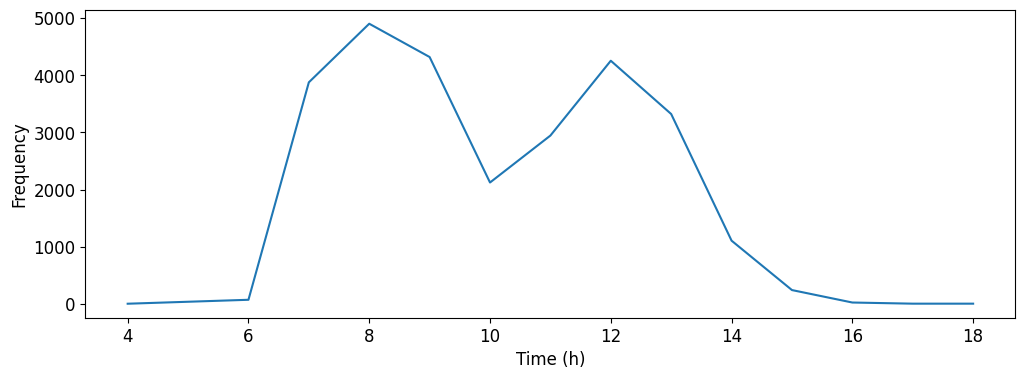

In [11]:
ax = services.date.groupby(services.date.dt.hour).count().plot()
ax.set_xlabel("Time (h)")
ax.set_ylabel("Frequency");

Above: aggreagte number of services (containers being emptied) by time-of-day, over all of Q1.
The coffee break around 10-11 is clearly visible in the data.

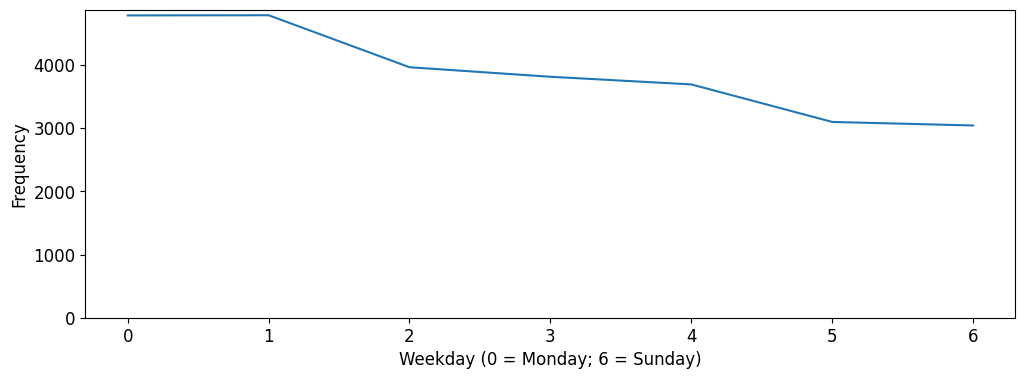

In [12]:
ax = services.date.groupby(services.date.dt.weekday).count().plot()
ax.set_ylim(bottom=0)
ax.set_xlabel("Weekday (0 = Monday; 6 = Sunday)")
ax.set_ylabel("Frequency");

Above: most emptying occurs on Monday and Tuesday, with servicing dropping gradually later on.
Services occur on every weekday, however, so this might be a planning/staffing/equipment decision?

## A single container

Now I'll focus on a single container.
I'm opting for the container with ID 1836, since that's the one on my street corner :-).

In [13]:
my_container = '1836'
my_arrivals = arrivals[arrivals.container == my_container]
my_services = services[services.container == my_container]

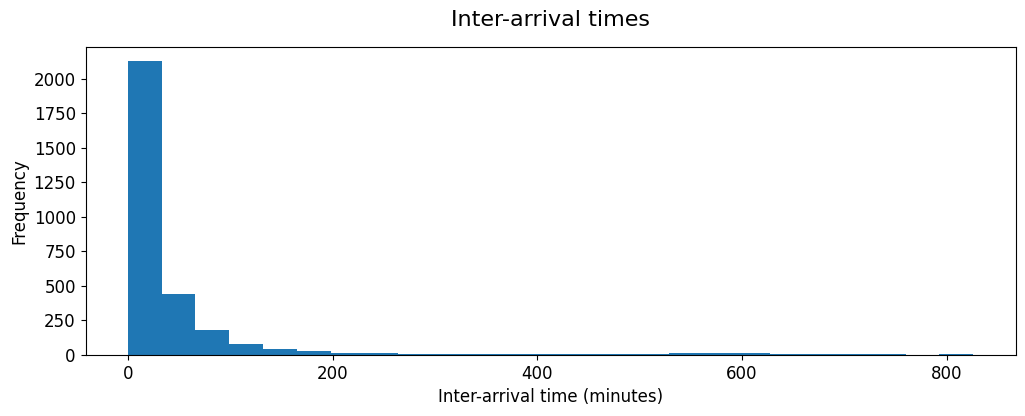

In [14]:
interarrivals = my_arrivals.date.diff(1).astype('timedelta64[m]')
ax = interarrivals.plot.hist(bins=25)
ax.set_title("Inter-arrival times")
ax.set_xlabel("Inter-arrival time (minutes)")
ax.set_ylabel("Frequency");

Above: inter-arrival times (in seconds) for 'my' container (ID 1836). 
These are the times between successive arrivals. 
Looks very exponential to me (with a few long outliers, but no matter), as it should be.

In [15]:
def make_event_list():
    a_events = my_arrivals.date.to_frame()
    a_events['arrival'] = 1

    s_events = my_services.date.to_frame()
    s_events['arrival'] = 0

    events = pd.concat([a_events, s_events]).sort_values(by='date')

    cumsum = 0
    arrivals = events.arrival.values
    stored = np.zeros(len(events))

    for idx in range(len(events)):
        cumsum = cumsum + 1 if arrivals[idx] else 0
        stored[idx] = cumsum

    events['stored'] = stored

    return events

In [16]:
events = make_event_list()

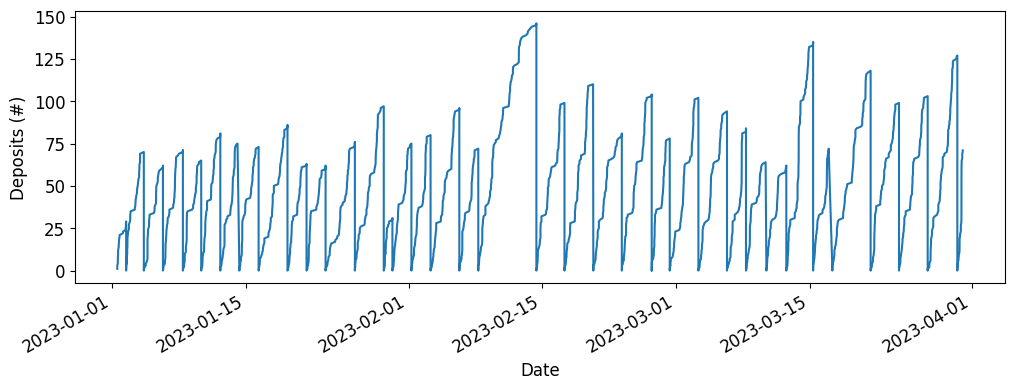

In [17]:
ax = events.plot(x='date', y='stored', legend=False)
ax.set_xlabel("Date")
ax.set_ylabel("Deposits (#)");

Above: the arrivals and services plotted in a single figure.
Each service resets the number of deposits in the container to zero.
Again, the strike around mid-February is clearly visible.
The arrival pattern is also highly regular.